In [1]:
import os
import numpy as np
import cv2
import sys
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.gridspec import GridSpec
from timeit import default_timer as timer
from datetime import timedelta

BASE_DIR = os.path.dirname('./')
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(ROOT_DIR)

import yaml
import logging

from lib.helpers.dataloader_helper import build_dataloader
from lib.helpers.model_helper import build_model

In [2]:
mode = 'test' # test, eval, train
config = 'lib/kitti.yaml'

def create_logger(log_file):
    log_format = '%(asctime)s  %(levelname)5s  %(message)s'
    logging.basicConfig(level=logging.INFO, format=log_format, filename=log_file)
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    console.setFormatter(logging.Formatter(log_format))
    logging.getLogger(__name__).addHandler(console)
    return logging.getLogger(__name__)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


# load cfg
assert (os.path.exists(config))
cfg = yaml.load(open(config, 'r'), Loader=yaml.Loader)
os.makedirs(cfg['trainer']['log_dir'], exist_ok=True)
logger = create_logger(os.path.join(cfg['trainer']['log_dir'], 'train.log'))
cfg['dataset']['batch_size'] = 1

import shutil
if mode != 'eval':
    if not mode != 'test':
        if os.path.exists(os.path.join(cfg['trainer']['log_dir'], 'lib/')):
            shutil.rmtree(os.path.join(cfg['trainer']['log_dir'], 'lib/'))
    if not mode != 'test':
        shutil.copytree('./lib', os.path.join(cfg['trainer']['log_dir'], 'lib/'))
    

#  build dataloader
train_loader, val_loader, test_loader = build_dataloader(cfg['dataset'])

# build model
model = build_model(cfg['model'], train_loader.dataset.cls_mean_size)


Using device: cuda

NVIDIA GeForce RTX 3060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
class detectionInfo(object):
    def __init__(self, line):
        #print('line: name=%s truncated=%f occluded=%f alpha=%f\n bbox=[%f %f %f %f]\n dimensions=[%f %f %f]\n location=[%f %f %f]\n rotation_y=%f score=%f' % (line[0], npline[0], npline[1], npline[2], npline[3], npline[4], npline[5], npline[6], npline[7], npline[8], npline[9], npline[10], npline[11], npline[12], npline[13], npline[14]))

        self.name = line[0]

        self.truncation = np.float64(line[1])
        self.occlusion = int(line[2])

        # local orientation = alpha + pi/2
        self.alpha = np.float64(line[3])

        # in pixel coordinate
        self.xmin = int(line[4])
        self.ymin = int(line[5])
        self.xmax = int(line[6])
        self.ymax = int(line[7])

        # height, weigh, length in object coordinate, meter
        self.h = np.float64(line[8])
        self.w = np.float64(line[9])
        self.l = np.float64(line[10])

        # x, y, z in camera coordinate, meter
        self.tx = np.float64(line[11])
        self.ty = np.float64(line[12])
        self.tz = np.float64(line[13])

        # global orientation [-pi, pi]
        self.rot_global = np.float64(line[14])

        # score
        self.score = np.float64(line[15])

In [4]:
def compute_birdviewbox(obj, shape, scale):
    h = obj.h * scale
    w = obj.w * scale
    l = obj.l * scale
    x = obj.tx * scale
    y = obj.ty * scale
    z = obj.tz * scale
    rot_y = obj.rot_global

    R = np.array([[-np.cos(rot_y), np.sin(rot_y)],
                  [np.sin(rot_y), np.cos(rot_y)]])
    t = np.array([x, z]).reshape(1, 2).T

    x_corners = [0, l, l, 0]  # -l/2
    z_corners = [w, w, 0, 0]  # -w/2

    x_corners += -w / 2
    z_corners += -l / 2

    # bounding box in object coordinate
    corners_2D = np.array([x_corners, z_corners])
    # rotate
    corners_2D = R.dot(corners_2D)
    # translation
    corners_2D = t - corners_2D
    # in camera coordinate
    corners_2D[0] += int(shape/2)
    corners_2D = (corners_2D).astype(np.int16)
    corners_2D = corners_2D.T

    return np.vstack((corners_2D, corners_2D[0,:]))

def draw_birdeyes(ax2, obj, shape, color):
    scale = 15
    pred_corners_2d = compute_birdviewbox(obj, shape, scale)
    codes = [Path.LINETO] * pred_corners_2d.shape[0]
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    pth = Path(pred_corners_2d, codes)
    p = patches.PathPatch(pth, fill=False, color=color)
    ax2.add_patch(p)

def draw_2Dbox(ax, obj, color):
    xmin = obj.xmin
    xmax = obj.xmax
    ymin = obj.ymin
    ymax = obj.ymax
    width = xmax - xmin
    height = ymax - ymin

    ax.add_patch(patches.Rectangle((xmin, ymin), width, height, fill=False, color='red'))

def compute_3Dbox(P2, obj):
    R = np.array([[np.cos(obj.rot_global), 0, np.sin(obj.rot_global)],
                  [0, 1, 0],
                  [-np.sin(obj.rot_global), 0, np.cos(obj.rot_global)]])

    x_corners = [0, obj.l, obj.l, obj.l, obj.l, 0, 0, 0]  # -l/2
    y_corners = [0, 0, obj.h, obj.h, 0, 0, obj.h, obj.h]  # -h
    z_corners = [0, 0, 0, obj.w, obj.w, obj.w, obj.w, 0]  # -w/2

    x_corners = [i - obj.l / 2 for i in x_corners]
    y_corners = [i - obj.h for i in y_corners]
    z_corners = [i - obj.w / 2 for i in z_corners]

    corners_3D = np.array([x_corners, y_corners, z_corners])
    corners_3D = R.dot(corners_3D)
    corners_3D += np.array([obj.tx, obj.ty, obj.tz]).reshape((3, 1))

    corners_3D_1 = np.vstack((corners_3D, np.ones((corners_3D.shape[-1]))))
    corners_2D = P2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]
    corners_2D = corners_2D[:2]

    return corners_2D

def draw_3Dbox(ax, P2, obj, color):
    corners_2D = compute_3Dbox(P2, obj)

    # draw all lines through path
    # https://matplotlib.org/users/path_tutorial.html
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]
    bb3d_on_2d_lines_verts = corners_2D[:, bb3d_lines_verts_idx]
    verts = bb3d_on_2d_lines_verts.T
    codes = [Path.LINETO] * verts.shape[0]
    codes[0] = Path.MOVETO
    # codes[-1] = Path.CLOSEPOLYq
    pth = Path(verts, codes)
    p = patches.PathPatch(pth, fill=False, color=color, linewidth=2)

    width = corners_2D[:, 3][0] - corners_2D[:, 1][0]
    height = corners_2D[:, 2][1] - corners_2D[:, 1][1]
    # put a mask on the front
    front_fill = patches.Rectangle((corners_2D[:, 1]), width, height, fill=True, color=color, alpha=0.4)
    ax.add_patch(p)
    ax.add_patch(front_fill)

In [5]:
def visualization(image, calib, detections, drawBird):
    P2 = calib[0].P2

    fig = plt.figure(figsize=(20.00, 5.12), dpi=100)

    # fig.tight_layout()
    gs = GridSpec(1, 4)
    gs.update(wspace=0)  # set the spacing between axes.

    ax = fig.add_subplot(gs[0, :3])
    if drawBird:
        ax2 = fig.add_subplot(gs[0, 3:])

    shape = 900

    for line_p in detections:
        obj = detectionInfo(line_p)
        truncated = np.abs(float(obj.truncation))
        occluded = np.abs(float(obj.occlusion))
        trunc_level = 255

        # truncated object in dataset is not observable
        if truncated < trunc_level:
            color = 'green'
            if obj.name == 'Cyclist':
                color = 'yellow'
            elif obj.name == 'Pedestrian':
                color = 'cyan'
            
            #draw_2Dbox(ax, obj, color)
            draw_3Dbox(ax, P2, obj, color)
            if drawBird:
                draw_birdeyes(ax2, obj, shape, color)

    # visualize 3D bounding box
    ax.imshow(image)
    ax.set_xticks([]) #remove axis value
    ax.set_yticks([])

    if drawBird:
        birdimage = np.zeros((shape, shape, 3), np.uint8)
        # plot camera view range
        x1 = np.linspace(0, shape / 2)
        x2 = np.linspace(shape / 2, shape)
        ax2.plot(x1, shape / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
        ax2.plot(x2, x2 - shape / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
        ax2.plot(shape / 2, 0, marker='+', markersize=16, markeredgecolor='red')

        # visualize bird eye view
        ax2.imshow(birdimage, origin='lower')
        ax2.set_xticks([])
        ax2.set_yticks([])

    plt.show()



In [6]:
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from lib.helpers.save_helper import load_checkpoint
from lib.helpers.decode_helper import extract_dets_from_outputs
from lib.helpers.decode_helper import decode_detections
from lib.datasets.kitti_utils import get_affine_transform

class PrintHelper(object):
    def __init__(self, data_loader):
        self.data_loader = data_loader

    def getPrintables(self, idx):
        dataset = self.data_loader.dataset

        img = dataset.get_image(idx)
        calibs = [dataset.get_calib(idx)]
        
        
        return idx, img, calibs, dataset.resolution, dataset.downsample, dataset.mean, dataset.std, dataset.cls_mean_size


class Printer(object):
    def __init__(self, cfg, model, logger):
        self.cfg = cfg
        self.model = model
        self.model.eval()

        self.logger = logger
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if self.cfg.get('resume_model', None):
            load_checkpoint(
                model = self.model,
                optimizer = None,
                filename = cfg['resume_model'],
                logger = self.logger,
                map_location=self.device
            )
        self.model.to(self.device)

    def print(self, idx, img, calibs, resolution, downsample, mean, std, cls_mean_size):
        img_size = np.array(img.size)

        center = np.array(img_size) / 2
        crop_size = img_size
        coord_range = np.array([center-crop_size/2,center+crop_size/2]).astype(np.float32)

        trans, trans_inv = get_affine_transform(center, crop_size, 0, resolution, inv=1)
        inputs = img.transform(tuple(resolution.tolist()),
                            method=Image.AFFINE,
                            data=tuple(trans_inv.reshape(-1).tolist()),
                            resample=Image.BILINEAR)
        inputs = np.array(inputs).astype(np.float32) / 255.0
        #inputs = (inputs - mean) / std
        inputs = inputs.transpose(2, 0, 1)  # C * H * W

        features_size = resolution // downsample
        info = {'img_id': np.asarray([idx]),
                'img_size': np.asarray([img_size]),
                'bbox_downsample_ratio': np.asarray([img_size/features_size])}
        
        torch.set_grad_enabled(False)
        inputs = torch.Tensor(inputs).unsqueeze(0).to(self.device)
        calib = torch.Tensor(calibs[0].P2).unsqueeze(0).to(self.device)
        coord_ranges = torch.Tensor(coord_range).unsqueeze(0).to(self.device)
        outputs = self.model(inputs, coord_ranges, calib, K=50, mode='test')

        dets = extract_dets_from_outputs(outputs=outputs, K=50)
        dets = dets.detach().cpu().numpy()
        # get corresponding calibs & transform tensor to numpy
        info = {key: val for key, val in info.items()}

        dets = decode_detections(
            dets = dets,
            info = info,
            calibs = calibs,
            cls_mean_size=cls_mean_size,
            threshold = self.cfg['threshold']
        )
        dets = dets[idx]
        preds = []
        class_map = {
            0: 'Pedestrian', 
            1: 'Car', 
            2: 'Cyclist'
        }

        for d in dets:
            cls = class_map[d[0]]
            tmp = [cls, 0.0, 0]
            tmp.extend(d[1:])
            preds.append(tmp)

        return preds

# evaluation mode
printer = Printer(cfg['tester'], model, logger)
if mode == 'eval':
    print('evaluation mode')
    printHelper = PrintHelper(val_loader)
elif mode == 'test':
    print('test mode')
    printHelper = PrintHelper(test_loader)
else:
    print('train mode')
    printHelper = PrintHelper(train_loader)

test mode


In [7]:
idx = 0

import matplotlib
matplotlib.use('GTK3Agg') 


0


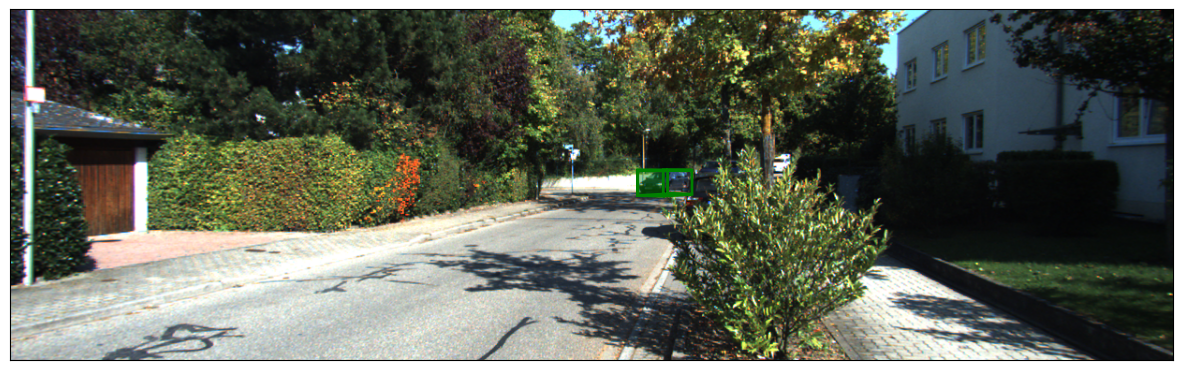

0:00:00.569323


In [8]:
print(idx)
torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
start_time = timer()

for x in range(1):
    idx, img, calibs, resolution, downsample, mean, std, cls_mean_size = printHelper.getPrintables(idx)
    preds = printer.print(idx, img, calibs, resolution, downsample, mean, std, cls_mean_size)

    visualization(img, calibs, preds, False)
    idx = idx +1

torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
end_time = timer()
print(timedelta(seconds=end_time - start_time))

idx = idx + 10